In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import img_to_array, array_to_img
import skimage
import keras
from keras import backend as K
from keras.datasets import fashion_mnist
import tensorflow as tf
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from keras import Model
from keras.layers import concatenate
from sklearn.manifold import TSNE

In [10]:
from sklearn.model_selection import train_test_split
train_data  = pd.read_csv('/content/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/fashion-mnist_test.csv')
train_X = np.array(train_data.iloc[:,1:])
test_X = np.array(test_data.iloc[:,1:])
train_Y = np.array (train_data.iloc[:,0])[:10000]
test_Y = np.array(test_data.iloc[:,0])[:10000]

train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X] * 3)
train_X.shape, test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [11]:
train_X = train_X.reshape(-1, 28, 28, 3)
test_X= test_X.reshape(-1, 28, 28, 3)

train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32))) for im in train_X])[:10000]
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32))) for im in test_X])[:10000]
train_X.shape, test_X.shape

((10000, 32, 32, 3), (10000, 32, 32, 3))

In [12]:
train_groups = [train_X[np.where(train_Y==i)[0]] for i in np.unique(train_Y)]
test_groups = [test_X[np.where(test_Y==i)[0]] for i in np.unique(train_Y)]

In [13]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [1009, 972, 951, 1012, 979, 1008, 1022, 1037, 974, 1036]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [16]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow import keras
from tensorflow.keras import layers

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [24]:
history = model.fit(train_X, to_categorical(train_Y), epochs = 4, batch_size = 16, validation_split = 0.2)

Epoch 1/4
500/500 [==============================] - 269s 481ms/step - loss: 0.7952 - accuracy: 0.7381 - val_loss: 0.7725 - val_accuracy: 0.7440
Epoch 2/4
500/500 [==============================] - 230s 459ms/step - loss: 0.4907 - accuracy: 0.8382 - val_loss: 1.2752 - val_accuracy: 0.7545
Epoch 3/4
500/500 [==============================] - 230s 461ms/step - loss: 0.4155 - accuracy: 0.8562 - val_loss: 0.4430 - val_accuracy: 0.8430
Epoch 4/4
500/500 [==============================] - 231s 462ms/step - loss: 0.3602 - accuracy: 0.8741 - val_loss: 0.4657 - val_accuracy: 0.8450


In [25]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

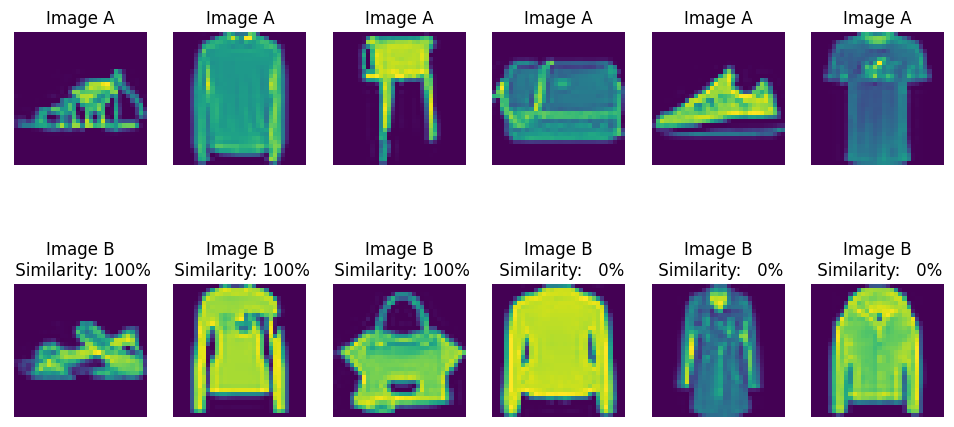

In [26]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [29]:
img_a_in = tf.keras.layers.Input(shape=train_X.shape[1:], name='ImageA_Input')
img_b_in = tf.keras.layers.Input(shape=train_X.shape[1:], name='ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name='features')
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs=[img_a_feat, img_b_feat], outputs=[features], name='Siamese_model')
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 features (Concatenate)         (None, 20)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 16)           336         ['features[1][0]']   

In [30]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title(f'Image A\n Actual: {100 * c_d}')
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title(f'Image B\n Predicted: {int(100 * p_d[0])}')
        ax2.axis('off')
        
    return fig

1/1 [==============================] - 0s 130ms/step


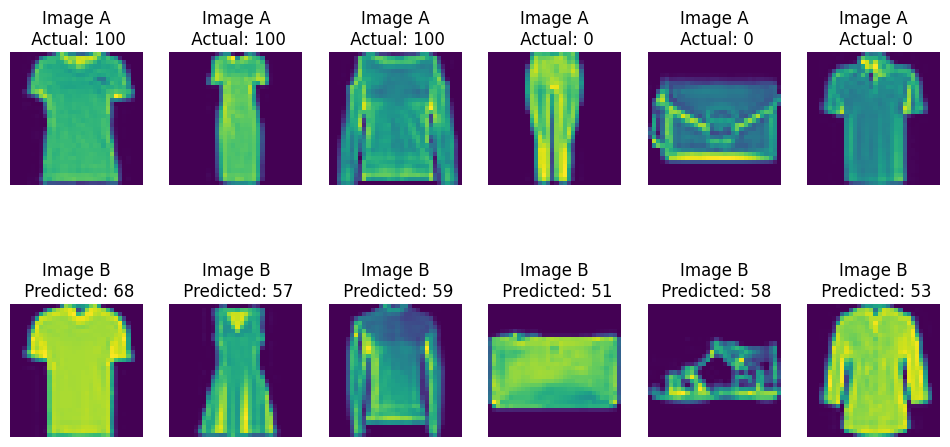

In [31]:
_ = show_model_output()

In [32]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size // 2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

In [33]:
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(
                                siam_gen(train_groups),
                                steps_per_epoch=500,
                                validation_data=([model.predict(valid_a), model.predict(valid_b)], valid_sim),
                                epochs=2,
                                verbose=True)

1/1 [==============================] - 0s 130ms/step
Epoch 1/2
500/500 [==============================] - 261s 520ms/step - loss: 0.5810 - mae: 0.4026 - val_loss: 0.5150 - val_mae: 0.3785
Epoch 2/2
1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 30ms/step


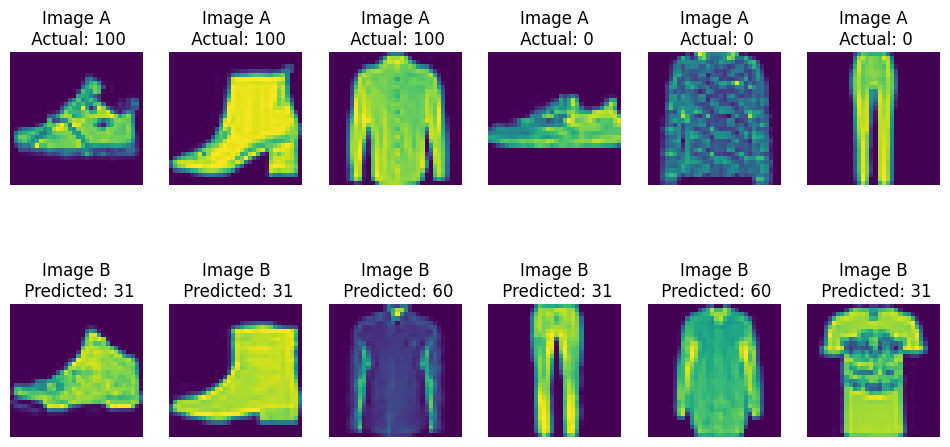

In [34]:
_ = show_model_output()

In [35]:
x_test_features = model.predict(test_X, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 37s 464ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 0.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.494942
[t-SNE] KL divergence a

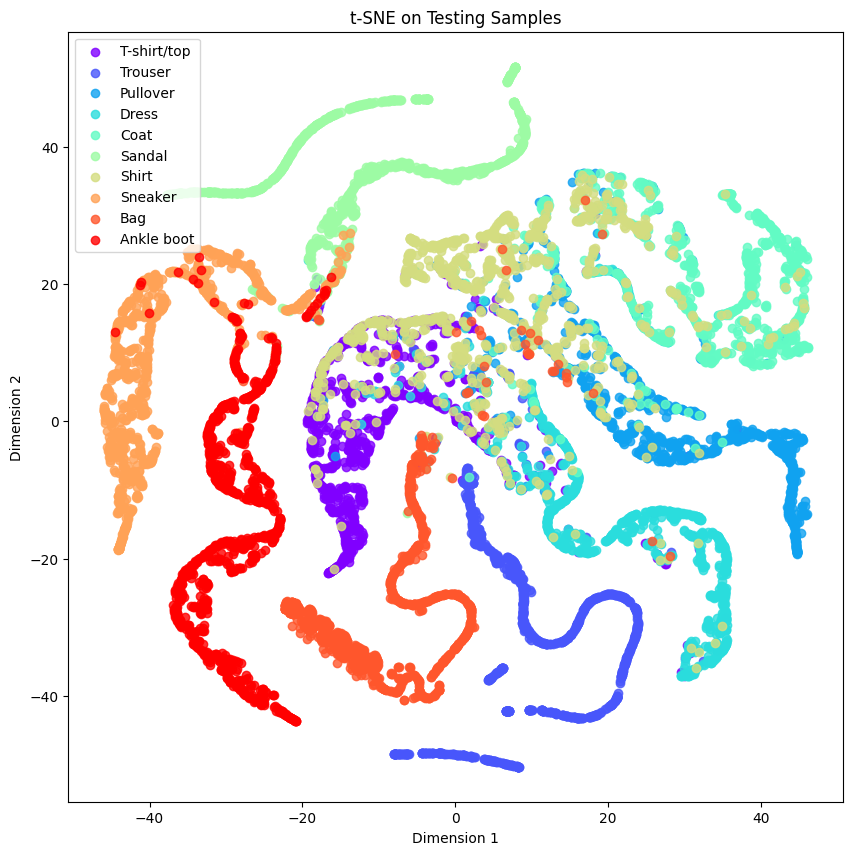

In [36]:
obj_categories = [
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(test_Y == c_group), 0],
                tsne_features[np.where(test_Y == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)